<a href="https://colab.research.google.com/github/mofuoku417/Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Price-Using-Machine-Learning-Techniques/blob/main/SVR_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [96]:
import warnings
from math import sqrt

import matplotlib.dates as mdates
import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
import xgboost as xgb
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from gluonts.evaluation.backtest import make_evaluation_predictions
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm



# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

2.6.0


In [110]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer

###Write function for numeric computation

In [94]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the root mean squared error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#Calculate the mean absolute percentage error
def MAPE(y_true, y_pred): 
    mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [25]:
df = pd.read_csv('/content/gdrive/MyDrive/raw_data/df3.csv')
df.rename({'Month': 'date','Unnamed: 0': 'index'}, axis=1, inplace=True)
df.set_index('date', inplace=True)
df.head()

,index,cpo_pri,cno_pri,sbo_pri,pno_pri
date,,,,,
2002-02-01,0,323,455,468.0,844.0
2002-03-01,1,345,546,485.0,799.0
2002-04-01,2,362,595,466.0,718.0
2002-05-01,3,376,636,442.0,614.0
2002-06-01,4,383,738,429.0,619.0


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230 entries, 2002-02-01 to 2021-03-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cno_pri  230 non-null    int64  
 1   sbo_pri  230 non-null    float64
 2   pno_pri  230 non-null    float64
 3   cpo_pri  230 non-null    int64  
dtypes: float64(2), int64(2)
memory usage: 19.0+ KB


In [30]:
# We split our dataset to be able to evaluate our models

resultsDict = {}
predictionsDict = {}

split_date = '2018-01'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

191 days of training data 
 39 days of testing data 


In [43]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [36]:
X_train_df, y_train = create_time_features(
    df_training, target='cpo_pri')
X_test_df, y_test = create_time_features(df_test, target='cpo_pri')
scaler = StandardScaler()
scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
X_train = scaler.transform(X_train_df)
X_test = scaler.transform(X_test_df)

X_train_df = pd.DataFrame(X_train, columns=X_train_df.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test_df.columns)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc_X = MinMaxScaler()
sc_y = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train.reshape(-1,1))
y_test = sc_y.transform(y_test.reshape(-1,1))

In [ ]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [41]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
svr_pred = reg.predict(X_test)

In [105]:
MAE_svr = mean_absolute_error(y_test, svr_pred)
print('MAE value of the SVR Model is:', MAE_svr)

#MDA_svr = mda(y_test, svr_pred)
#print('MDA value of the SVR Model is:', MDA_svr)

MAPE_svr = mean_absolute_percentage_error(y_test, svr_pred)
print('MAPE value of the SVR Model is:', (MAPE_svr))


RMSE_svr = mean_squared_error(y_test,svr_pred, squared=False)
print('RMSE value of the SVR Model is:', (RMSE_svr))


MSE_svr = mean_squared_error(y_test,svr_pred)
print('MSE value of the SVR Model is:', (MSE_svr))

MAE value of the SVR Model is: 247.1263791161241
MAPE value of the SVR Model is: 23.197396032069385
RMSE value of the SVR Model is: 360.7615259691854
MSE value of the SVR Model is: 130148.87861961525


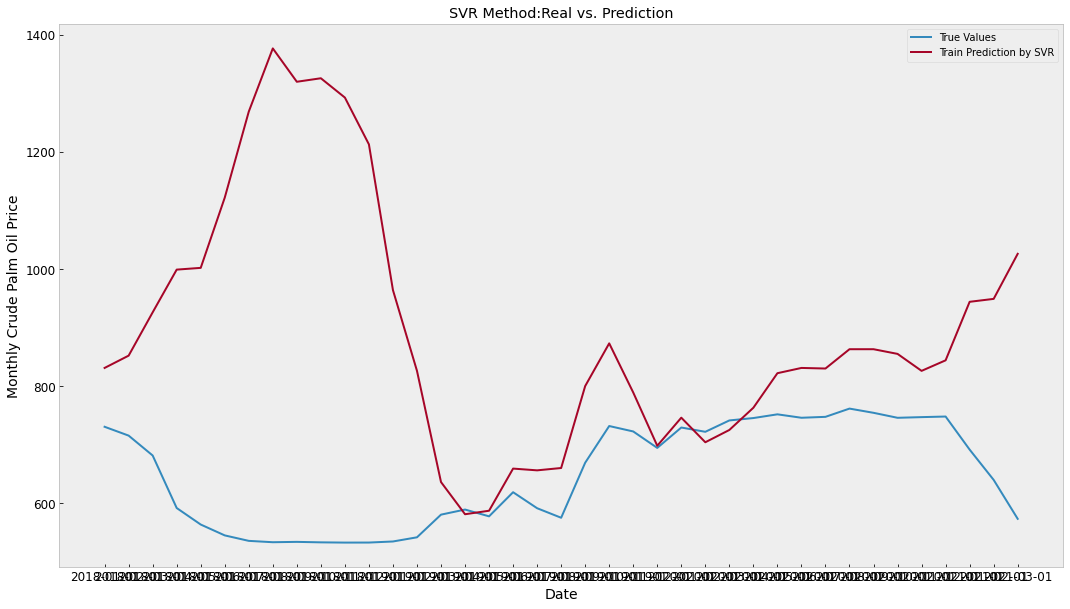

In [90]:
plt.figure(figsize=(18,10))
plt.grid()
plt.plot(y_test.index, svr_pred, label = 'Train')
plt.plot(y_test,  label = 'Test')
plt.plot(svr_pred = 'mlp forecast')
plt.legend(['True Values', 'Train Prediction by SVR', 'Test Prediction by SVR'],loc='best')
plt.title('SVR Method:Real vs. Prediction')
plt.ylabel('Monthly Crude Palm Oil Price')
plt.xlabel('Date')
plt.show()

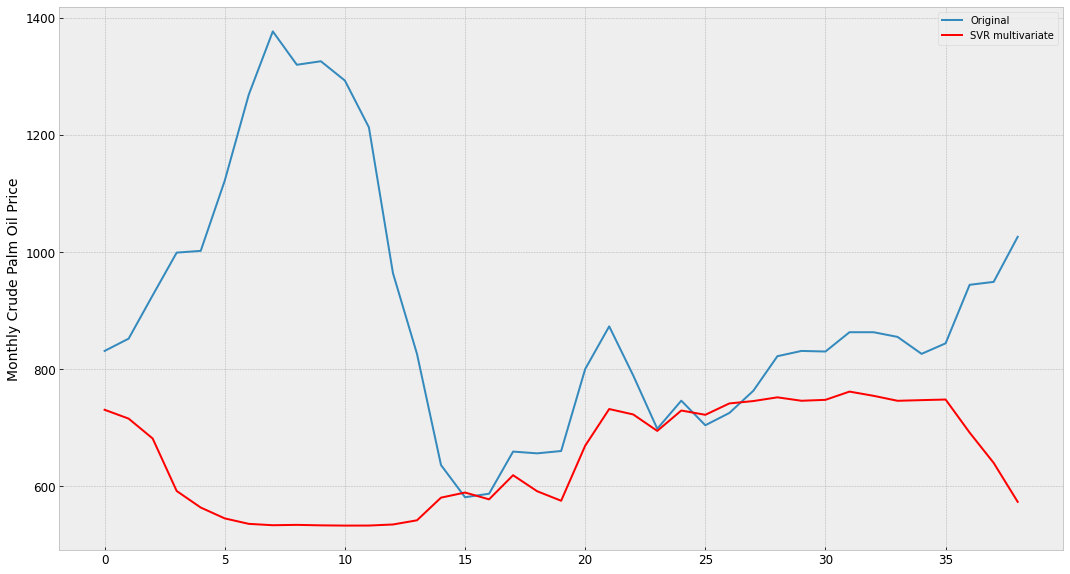

In [125]:
plt.figure(figsize=(18,10))
plt.plot(df_test.cpo_pri.values, label='Original')
plt.plot(svr_pred, color='red', label='SVR multivariate')
plt.ylabel('Monthly Crude Palm Oil Price')
#plt.xlabel('Date')
plt.legend()

###Apply Grid Search to SVR Model

In [139]:
#tune parameters
param_grid = {'C': [0.1, 1, 10, 100],
             'gamma' :[1, 0.1, 0.01, 0.001,],
             'kernel' :['rbf', 'poly', 'linear'],
              'epsilon': [1e-4, 1e-3]}
scorer = make_scorer(mean_squared_error, greater_is_better=False)
model = SVR()
grid = GridSearchCV(SVR(),param_grid,cv = 10, scoring=scorer, refit = True, verbose =3)
grid.fit(X_train,np.ravel(y_train))
svr_gpred = grid.predict(X_test)

Fitting 10 folds for each of 96 candidates, totalling 960 fits
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-7952.690, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-11563.089, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-24913.770, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-8934.071, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-32115.819, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=1, kernel=rbf ......................
[CV]  C=0.1, epsilon=0.0001, gamma=1, kernel=rbf, score=-27987.305, total=   0.0s
[CV] C=0.1, epsilon=0

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-3803.698, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-687.609, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly ...................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=poly, score=-35809.533, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=-5081.157, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=-8949.906, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=-22927.531, total=   0.0s
[CV] C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear .................
[CV]  C=0.1, epsilon=0.0001, gamma=0.1, kernel=linear, score=-8

[Parallel(n_jobs=1)]: Done 960 out of 960 | elapsed:    8.3s finished


In [150]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

#best score
print(grid.best_score_)

{'C': 10, 'epsilon': 0.0001, 'gamma': 1, 'kernel': 'linear'}
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.0001, gamma=1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-3125.3551995719044


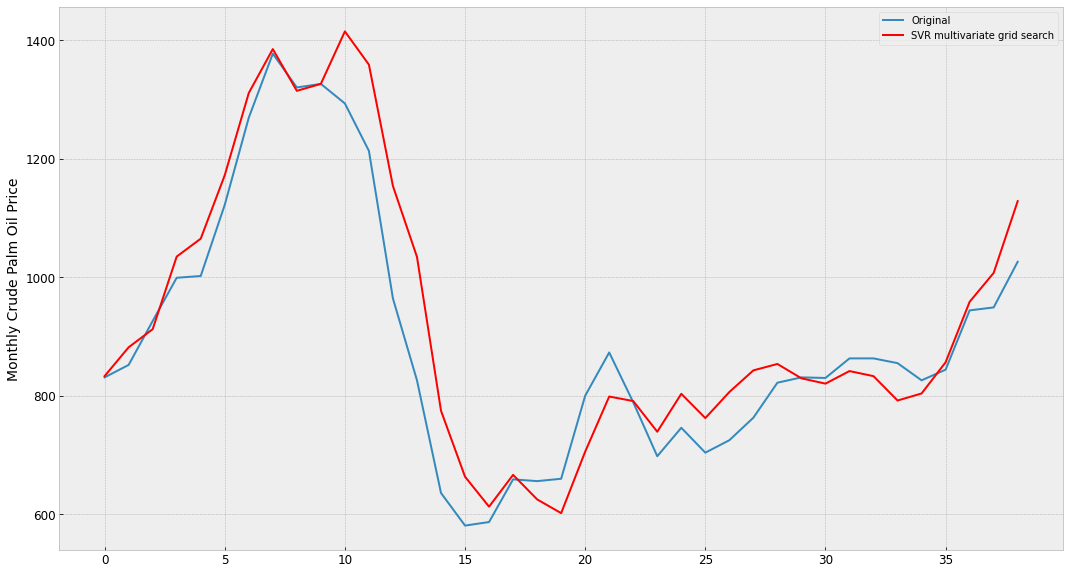

In [140]:
plt.figure(figsize=(18,10))
plt.plot(df_test.cpo_pri.values, label='Original')
plt.plot(svr_gpred, color='red', label='SVR multivariate grid search')
plt.ylabel('Monthly Crude Palm Oil Price')
#plt.xlabel('Date')
plt.legend()

In [137]:
MAE = mean_absolute_error(y_test, svr_gpred)
print('MAE value of the SVR Model is:', MAE)

#MDA_svr = mda(y_test, svr_gpred)
#print('MDA value of the SVR Model is:', MDA_svr)

MAPE = mean_absolute_percentage_error(y_test, svr_gpred)
print('MAPE value of the SVR Model is:', (MAPE))


RMSE = mean_squared_error(y_test,svr_gpred, squared=False)
print('RMSE value of the SVR Model is:', (RMSE))


MSE = mean_squared_error(y_test,svr_gpred)
print('MSE value of the SVR Model is:', (MSE))

MAE value of the SVR Model is: 54.18335748712352
MAPE value of the SVR Model is: 6.399181468751205
RMSE value of the SVR Model is: 74.05650580133114
MSE value of the SVR Model is: 5484.366051502592
